In [1]:
import numpy as np
import pandas as pd
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import OrderedDict
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [2]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda:3')
else:
    device = torch.device('cpu')
    
print(device)
device =  torch.device('cpu')

cpu


In [3]:
print(device)

cpu


In [4]:
# the deep neural network
class MLP(torch.nn.Module):
    def __init__(self, layers, activation="relu", init="xavier"):
        super(MLP, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        if activation == "relu":
            self.activation = torch.nn.ReLU()
        elif activation == "tanh":
            self.activation = torch.nn.Tanh()
        elif activation == "gelu":
            self.activation = torch.nn.GELU()
        else:
            raise ValueError("Unspecified activation type")
        
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)

        if init=="xavier":
            self.xavier_init_weights()
        elif init=="kaiming":
            self.kaiming_init_weights()
    
    def xavier_init_weights(self):
        with torch.no_grad():
            print("Initializing Network with Xavier Initialization..")
            for m in self.layers.modules():
                if hasattr(m, 'weight'):
                    nn.init.xavier_uniform_(m.weight)
                    m.bias.data.fill_(0.0)

    def kaiming_init_weights(self):
        with torch.no_grad():
            print("Initializing Network with Kaiming Initialization..")
            for m in self.layers.modules():
                if hasattr(m, 'weight'):
                    nn.init.kaiming_uniform_(m.weight)
                    m.bias.data.fill_(0.0)
                        
    def forward(self, x):
        out = self.layers(x)
        return out
    
class DataGenerator(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        
    def __getitem__(self, index):
        return self.X[index], self.Y[index]
    
    def __len__(self):
        return len(self.X)

In [5]:
data_df = pd.read_csv("all_data_lake_modeling_in_time_wHeat.csv")
data_df = data_df.drop(columns=['time'])
data_df

,depth,AirTemp_degC,Longwave_Wm-2,Latent_Wm-2,Sensible_Wm-2,Shortwave_Wm-2,lightExtinct_m-1,ShearVelocity_mS-1,ShearStress_Nm-2,Area_m2,...,buoyancy,diffusivity,temp_heat00,temp_diff01,day_of_year,time_of_day,temp_mix02,temp_conv03,obs_temp,input_obs
0,1,10.715021,695.937161,-56.268384,-23.291619,0.0,0.255324,1.085448,0.002290,36000000.0,...,-0.000006,0.000037,16.283408,16.149422,155,1,16.206994,16.241692,16.409,16.350
1,2,10.715021,695.937161,-56.268384,-23.291619,0.0,0.255324,1.085448,0.002290,36000000.0,...,-0.000006,0.000037,16.283408,16.267964,155,1,16.206994,16.247184,16.480,16.426
2,3,10.715021,695.937161,-56.268384,-23.291619,0.0,0.255324,1.085448,0.002290,36000000.0,...,-0.000007,0.000037,16.287068,16.286071,155,1,16.286071,16.251763,16.130,16.088
3,4,10.715021,695.937161,-56.268384,-23.291619,0.0,0.255324,1.085448,0.002290,36000000.0,...,0.000021,0.000037,16.291257,16.288695,155,1,16.288695,16.251763,15.827,15.789
4,5,10.715021,695.937161,-56.268384,-23.291619,0.0,0.255324,1.085448,0.002290,36000000.0,...,0.000180,0.000025,16.278268,16.270156,155,1,16.270156,16.256606,16.270,16.240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141570,21,21.695001,832.055902,-93.493728,-12.091248,0.0,1.162606,1.049822,0.002174,36000000.0,...,0.000637,0.000014,8.537687,8.537921,213,23,8.537921,8.537921,0.401,0.401
141571,22,21.695001,832.055902,-93.493728,-12.091248,0.0,1.162606,1.049822,0.002174,36000000.0,...,0.000474,0.000016,7.466041,7.466186,213,23,7.466186,7.466186,0.401,0.401
141572,23,21.695001,832.055902,-93.493728,-12.091248,0.0,1.162606,1.049822,0.002174,36000000.0,...,0.000307,0.000020,6.396040,6.396125,213,23,6.396125,6.396125,0.401,0.401
141573,24,21.695001,832.055902,-93.493728,-12.091248,0.0,1.162606,1.049822,0.002174,36000000.0,...,0.000134,0.000028,5.326140,5.326179,213,23,5.326179,5.326179,0.401,0.401


In [6]:
training_frac = 0.60
depth_steps = 25
number_days = len(data_df)//depth_steps
n_obs = int(number_days*training_frac)*depth_steps
print(f"Number of days total: {number_days}")
print(f"Number of training points: {n_obs}")

Number of days total: 5663
Number of training points: 84925


# Normalizing Data

In [7]:
data = data_df.values

train_data = data[:n_obs]
test_data = data[n_obs:]

#performing normalization on all the columns
scaler = StandardScaler()
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

# Training Heat Diffusion Model

In [8]:
input_columns = ['depth', 'AirTemp_degC', 'Longwave_Wm-2', 'Latent_Wm-2', 'Sensible_Wm-2', 'Shortwave_Wm-2',
                'lightExtinct_m-1', 'ShearVelocity_mS-1', 'ShearStress_Nm-2', 'Area_m2', 
                 'buoyancy', 'day_of_year', 'time_of_day', 'diffusivity' ,'temp_heat00']
output_columns = ['temp_diff01']

input_column_ix = [data_df.columns.get_loc(column) for column in input_columns]
output_column_ix = [data_df.columns.get_loc(column) for column in output_columns]

X_train, X_test = train_data[:,input_column_ix], test_data[:,input_column_ix]
y_train, y_test = train_data[:,output_column_ix], test_data[:,output_column_ix]

In [9]:
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")

X_train: (84925, 15), X_test: (56650, 15)
y_train: (84925, 1), y_test: (56650, 1)


In [10]:
#keeping track of the mean and standard deviations
train_mean = scaler.mean_
train_std = scaler.scale_

input_mean, input_std = train_mean[input_column_ix], train_std[input_column_ix]
output_mean, output_std = train_mean[output_column_ix], train_std[output_column_ix]

In [11]:
# Create data set
batch_size = 1000

assert batch_size % 25 ==0, "Batchsize has to be multiple of 25" 

train_dataset = DataGenerator(X_train, y_train)
test_dataset = DataGenerator(X_test, y_test)
# train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
# test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False)

In [12]:
layers = [X_train.shape[-1], 32, 32, y_train.shape[-1]]

model = MLP(layers, activation="gelu").to(device)

Initializing Network with Xavier Initialization..


In [13]:
lr = 1e-3
decay_rate = 0.1
decay_steps = 500


optimizer = torch.optim.Adam(model.parameters(), lr=lr, 
                         betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=decay_steps, gamma=decay_rate)

criterion = torch.nn.MSELoss()

In [14]:
print(model)

MLP(
  (activation): GELU()
  (layers): Sequential(
    (layer_0): Linear(in_features=15, out_features=32, bias=True)
    (activation_0): GELU()
    (layer_1): Linear(in_features=32, out_features=32, bias=True)
    (activation_1): GELU()
    (layer_2): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [15]:
# mean_diff = torch.tensor(input_mean[input_column_ix[13]]).to(device)
# std_diff = torch.tensor(input_std[input_column_ix[13]]).to(device)

# mean_temp = torch.tensor(input_mean[input_column_ix[14]]).to(device)
# std_temp = torch.tensor(input_std[input_column_ix[14]]).to(device)

# mean_out = torch.tensor(output_mean).to(device)
# std_out = torch.tensor(output_std).to(device)
    
# def implicit_diffusion(diff, temp, dt=3600, dx=1, depth_steps=25):
#     # de-normalise data
#     diff = diff * std_diff + mean_diff

#     # INPUT DATA FROM PREVIOUS MODULE
#     t = temp * std_temp + mean_temp # temperature profile from previous module output

#     # IMPLEMENTATION OF CRANK-NICHOLSON SCHEME
#     j = len(t)
#     y = torch.zeros((len(t), len(t)), dtype=torch.float64).to(device)

#     alpha = (dt/dx**2) * diff

#     az = - alpha # subdiagonal
#     bz = 2 * (1 + alpha) # diagonal
#     cz = - alpha # superdiagonal

#     bz[0] = 1
#     az[len(az)-2] = 0
#     bz[len(bz)-1] = 1
#     cz[0] = 0

#     az = az[1:,:]
#     cz = cz[:-1,:]

#     y = torch.diag(bz[:, 0])+torch.diag(az[:, 0],-1)+torch.diag(cz[:, 0],1) #slightly efficient way of computing the diagonal matrices
#     y[j-1, j-1] = 1
    
#     mn = torch.zeros_like(t)  
#     mn[0] = t[0]
#     mn[len(mn)-1] = t[len(t)-1]
    
#     mn[1:j-1] = alpha[1:j-1,0]*t[:j-2] + 2 * (1 - alpha[1:j-1,0])*t[1:j-1] + alpha[1:j-1,0]*t[1:j-1] #is be same as the loop
    
#     # DERIVED TEMPERATURE OUTPUT FOR NEXT MODULE
#     proj = torch.linalg.solve(y, mn)

#     mean, std, var = torch.mean(proj), torch.std(proj), torch.var(proj)
#     proj = (proj-mean_out)/std_out

#     proj = proj.to(torch.double)
#     return proj

In [16]:
print(input_column_ix)
print(input_column_ix[13])
print(input_column_ix[5])
print(input_column_ix[:2])
print(input_column_ix[11])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 16, 17, 13, 14]
13
5
[0, 1]
16


In [17]:
mean_diff = torch.tensor(input_mean[input_column_ix[13]]).to(device)
std_diff = torch.tensor(input_std[input_column_ix[13]]).to(device)

mean_temp = torch.tensor(input_mean[input_column_ix[14]]).to(device)
std_temp = torch.tensor(input_std[input_column_ix[14]]).to(device)

mean_out = torch.tensor(output_mean).to(device)
std_out = torch.tensor(output_std).to(device)
    
def implicit_diffusion(diff, temp, dt=3600, dx=1, depth_steps=25):
    # de-normalise data
    diff = diff * std_diff + mean_diff
    diff = diff.view(-1, depth_steps)
    
    # INPUT DATA FROM PREVIOUS MODULE
    t = temp * std_temp + mean_temp # temperature profile from previous module output
    t = t.view(-1, depth_steps)
    
    # IMPLEMENTATION OF CRANK-NICHOLSON SCHEME
#     len_t = t.shape[1]
    y = torch.zeros((t.shape[0], depth_steps, depth_steps), dtype=torch.float64).to(device)

    alpha = (dt/dx**2) * diff

    az = - alpha # subdiagonal
    bz = 2 * (1 + alpha) # diagonal
    cz = - alpha # superdiagonal
    
    bz[:, 0] = 1
    az[:, depth_steps-2] = 0
    bz[:, depth_steps-1] = 1
    cz[:, 0] = 0
    
    az = az[:,1:]
    cz = cz[:,:-1]

    y = torch.diag_embed(bz, offset=0)+torch.diag_embed(az,offset=-1)+torch.diag_embed(cz,offset=1) #slightly efficient way of computing the diagonal matrices
    y[:, depth_steps-1, depth_steps-1] = 1
    
    mn = torch.zeros_like(t)  
    mn[:, 0] = t[:, 0]
    mn[:,depth_steps-1] = t[:, depth_steps-1]
    
    mn[:, 1:depth_steps-1] = alpha[:, 1:depth_steps-1]*t[:, :depth_steps-2] + 2 * (1 - alpha[:,1:depth_steps-1])*t[:,1:depth_steps-1] + alpha[:,1:depth_steps-1]*t[:,1:depth_steps-1] #is be same as the loop
    
    # DERIVED TEMPERATURE OUTPUT FOR NEXT MODULE
    proj = torch.linalg.solve(y, mn)

    mean, std, var = torch.mean(proj), torch.std(proj), torch.var(proj)
    proj = (proj-mean_out)/std_out

    proj = proj.to(torch.float32)
    proj = proj.view(-1, 1)
    return proj

In [18]:
# diffusivity_true = torch.tensor(X_train[:,input_column_ix[13]], device=device).unsqueeze(1)
# temp_heat_true = torch.tensor(X_train[:,input_column_ix[14]], device=device)#.unsqueeze(1)
# mean_diff = torch.tensor(input_mean[input_column_ix[13]]).to(device)
# std_diff = torch.tensor(input_std[input_column_ix[13]]).to(device)
# print(mean_diff, std_diff)

# pred = implicit_diffusion(diff=diffusivity_true, 
#                           temp=temp_heat_true)

# print(torch.mean((pred-y_train)**2))

In [19]:
# time = 20
# # print(pred[25*time:25*(time+1)])
# # print(y_train[25*time:25*(time+1)])
# print((pred[25*time:25*(time+1)]-y_train[25*time:25*(time+1)]).abs())

In [20]:
# # test if the Crank-Nicholson scheme works

# temp = torch.rand(5,1).to(device)
# diff = torch.rand(5,1).to(device)
# print(temp), print(diff)
# implicit_diffusion(diff, temp, input_mean, input_std,
#                                  output_mean, output_std)

In [21]:
n_epochs = 1000

train_loss = []
test_loss = []
for it in tqdm(range(n_epochs)):
    loss_epoch = 0
    model.train()
    for x, y in iter(train_loader):
        x, y = x.to(device).float(), y.to(device).float()
        
        # get temperature input
        temp_input = x[:,14]
        
        optimizer.zero_grad()
        proj = model(x)
        
        pred = implicit_diffusion(proj, temp_input)
#         pred = pred.to(dtype=torch.float32)
        
#         print(pred.mean(), y.mean(), pred.std(), y.std())
        loss = criterion(pred, y)
        
        loss.backward()
        optimizer.step()
        loss_epoch += loss.detach().item()
    lr_scheduler.step()
    
    if it % 50 == 0:
        train_loss.append(loss_epoch/len(train_loader))
        model.eval()
        test_loss_epoch = 0
        for x, y in iter(test_loader):
            x, y = x.to(device).float(), y.to(device).float()
            temp_input = x[:,14] #* std + mean

            optimizer.zero_grad()
            proj = model(x)

            pred = implicit_diffusion(proj, temp_input)

            loss = criterion(pred, y)
            test_loss_epoch += loss.detach().item()
        test_loss.append(test_loss_epoch/len(test_loader))
        print(f"Epoch : {it}, Train_loss: {train_loss[-1]}, Test_loss: {test_loss[-1]}")
    

  0%|          | 1/1000 [00:01<30:21,  1.82s/it]

Epoch : 0, Train_loss: 0.007135356746285277, Test_loss: 3.830253387461294e-05


  5%|▌         | 51/1000 [03:00<1:27:26,  5.53s/it]

Epoch : 50, Train_loss: 1.4729562206091085e-05, Test_loss: 2.8482539052850354e-05


 10%|█         | 101/1000 [06:38<1:09:25,  4.63s/it]

Epoch : 100, Train_loss: 1.2526385200865608e-05, Test_loss: 2.8199221113729372e-05


 15%|█▌        | 151/1000 [10:02<1:04:34,  4.56s/it]

Epoch : 150, Train_loss: 1.1317995594093671e-05, Test_loss: 2.8224291574524453e-05


 20%|██        | 201/1000 [13:24<56:35,  4.25s/it]  

Epoch : 200, Train_loss: 1.0576021138737868e-05, Test_loss: 2.8224417212441677e-05


 25%|██▌       | 251/1000 [16:59<58:07,  4.66s/it]  

Epoch : 250, Train_loss: 1.0753472633950877e-05, Test_loss: 2.8215879227214475e-05


 30%|███       | 301/1000 [20:34<57:24,  4.93s/it]  

Epoch : 300, Train_loss: 1.0840617120693957e-05, Test_loss: 2.821622295238756e-05


 35%|███▌      | 351/1000 [24:03<58:11,  5.38s/it]

Epoch : 350, Train_loss: 1.1035515088973197e-05, Test_loss: 2.820688502668003e-05


 40%|████      | 401/1000 [27:46<46:44,  4.68s/it]

Epoch : 400, Train_loss: 1.0849129300956573e-05, Test_loss: 2.8178007612535894e-05


 45%|████▌     | 451/1000 [31:22<44:44,  4.89s/it]

Epoch : 450, Train_loss: 1.0659570280575495e-05, Test_loss: 2.81869081829842e-05


 50%|█████     | 501/1000 [34:54<37:30,  4.51s/it]

Epoch : 500, Train_loss: 1.007626523834701e-05, Test_loss: 2.818024027842432e-05


 55%|█████▌    | 551/1000 [38:33<38:20,  5.12s/it]

Epoch : 550, Train_loss: 1.0122339111095404e-05, Test_loss: 2.817959785604392e-05


 60%|██████    | 601/1000 [42:15<31:07,  4.68s/it]

Epoch : 600, Train_loss: 1.035991019628401e-05, Test_loss: 2.8181130306748265e-05


 65%|██████▌   | 651/1000 [46:01<28:37,  4.92s/it]

Epoch : 650, Train_loss: 1.0401620003155105e-05, Test_loss: 2.817975744843001e-05


 70%|███████   | 701/1000 [49:28<22:17,  4.47s/it]

Epoch : 700, Train_loss: 9.960209482575439e-06, Test_loss: 2.8180549187501974e-05


 75%|███████▌  | 751/1000 [52:59<18:45,  4.52s/it]

Epoch : 750, Train_loss: 1.026673312213354e-05, Test_loss: 2.8181105766347364e-05


 80%|████████  | 801/1000 [54:53<02:56,  1.13it/s]

Epoch : 800, Train_loss: 1.058447290715241e-05, Test_loss: 2.8182594752778594e-05


 85%|████████▌ | 851/1000 [55:32<02:18,  1.07it/s]

Epoch : 850, Train_loss: 1.05386611454271e-05, Test_loss: 2.8183885341716457e-05


 90%|█████████ | 901/1000 [56:13<01:28,  1.12it/s]

Epoch : 900, Train_loss: 1.037238949078635e-05, Test_loss: 2.8179618758466013e-05


 95%|█████████▌| 951/1000 [56:52<00:43,  1.14it/s]

Epoch : 950, Train_loss: 9.803451367213925e-06, Test_loss: 2.8177561226153846e-05


100%|██████████| 1000/1000 [57:30<00:00,  3.45s/it]


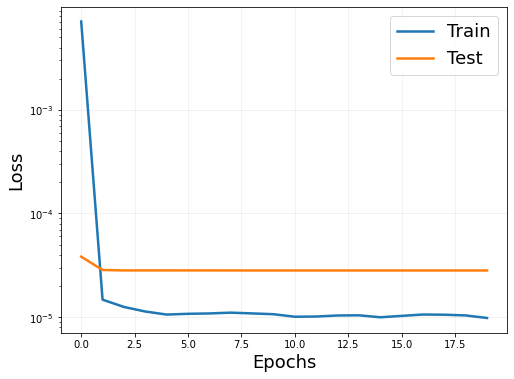

In [22]:
plt.figure(figsize=(8,6))
plt.plot(train_loss, label="Train", linewidth=2.5)
plt.plot(test_loss, label="Test", linewidth=2.5)
plt.grid("on", alpha=0.2)
plt.legend(fontsize=18)
plt.yscale("log")
plt.xlabel("Epochs", fontsize=18)
plt.ylabel("Loss", fontsize=18)
plt.show()

# Evaluating Results

In [23]:
def rmse(true, pred):
    return (((true-pred)**2).mean()**0.5).detach().cpu().numpy()

def l2_error(true, pred):
    return np.linalg.norm(pred.detach().cpu().numpy() - true.detach().cpu().numpy()) / np.linalg.norm(true.detach().cpu().numpy()) 

def compute_metrics(model, loader, mean=0.0, std=1.0):
    model.eval()
    y_ = []
    pred_ = []
    mean = torch.tensor(mean).to(device)
    std = torch.tensor(std).to(device)
    for x, y in iter(loader):
        x, y = x.to(device).float(), y.to(device).float()
        pred = model(x)
        
        temp_input = x[:,14]
        proj = model(x)
        pred = implicit_diffusion(proj, temp_input)        
        pred = pred.to(dtype=torch.float32)
        
#         print(torch.mean((pred-y)**2))
#         print(y.shape)
        
        y = y * std + mean
        pred = pred * std + mean
        
        y_.append(y)
        pred_.append(pred)
    y_ = torch.cat(y_, dim=0) 
    pred_ = torch.cat(pred_, dim=0)
    
    rmse_temp = rmse(y_, pred_)
    l2_error_temp = l2_error(y_, pred_)
    return rmse_temp, l2_error_temp

In [24]:
rmse_temp, l2_error_temp = compute_metrics(model, test_loader,  mean = output_mean, std = output_std)
print(f"Test Rmse of Temp: {rmse_temp}")
print(f"L2 Error  of Temp: {l2_error_temp}")

Test Rmse of Temp: 0.032774762208728124
L2 Error  of Temp: 0.0018684054069205104


In [25]:
rmse_temp, l2_error_temp = compute_metrics(model, train_loader,  mean = output_mean, std = output_std)
print(f"Train Rmse of Temp: {rmse_temp}")
print(f"L2 Error  of Temp: {l2_error_temp}")

Train Rmse of Temp: 0.019760469938610074
L2 Error  of Temp: 0.0012800967430585063


# Saving Model

In [26]:
PATH = f"./saved_models/heat_diffusion_model_time.pth"
torch.save(model.state_dict(), PATH)

In [27]:
output_mean

array([14.15055359])